In [0]:
from keras.layers import Input, Conv2D, Lambda, subtract, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy as np
import numpy.random as rng
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from PIL import Image

!git clone https://github.com/brendenlake/omniglot.git
!unzip -q omniglot/python/images_background.zip 

train_x = np.zeros((19280,105,105))
print(train_x.shape)
train_y = np.zeros((19280))

print(train_x.shape)

i=0
arc = os.path.join("images_background")
for alphabet in os.listdir(arc):
    for characters in os.listdir(os.path.join(arc,alphabet)):
        for sub in os.listdir(os.path.join(arc,alphabet,characters)):
            path = os.path.join(arc,alphabet,characters,sub)
            img = Image.open(path)
            train_x[i,:,:] = np.asarray(img.getdata()).reshape(img.size)
            train_y[i] = int(path[path.find('.png')-7:path.find('.png')-3])
            #print(train_y[i])
            i += 1  

Cloning into 'omniglot'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.
(19280, 105, 105)
(19280, 105, 105)


In [0]:
 def generate_trainset(train_x,train_y, size):
  
  pairs = [np.zeros((size,105,105,1)) for i in range(2)]
  targets = np.zeros((size))
  
  #print("pairs",np.asarray(pairs).shape,"targets",np.asarray(targets).shape)
  train_y_structured = train_y.reshape(-1,20)
  train_x_structured = train_x.reshape(-1,20,105,105)
  #print("structured x,",train_x_structured.shape)
  #print("structured y,",train_y_structured.shape)
  randed = rng.choice(train_y_structured.shape[0],size,replace=False)
  #print("trainx",train_x_structured[randed].shape,train_x_structured.shape)
  
  left = train_x_structured[0,0,:,:]
  right= train_x_structured[0,0,:,:]
  for i in range(0,size):
    if i%2 == 1:                        #getting a same char example
      class_of_char = rng.randint(963)
      #print("class same:",class_of_char)
      left =train_x_structured[class_of_char,rng.randint(19),:,:]
      right =train_x_structured[class_of_char,rng.randint(19),:,:]
      pairs[0][i,:,:,:] = left.reshape(105,105,1)
      pairs[1][i,:,:,:] = right.reshape(105,105,1)
      targets[i] = 1
      
    else:                                 #getting a different char example 
      indexes = rng.choice(963,size=2,replace=False)
      #print("two of em",indexes.shape,indexes)
      left = train_x_structured[indexes[0],rng.randint(19),:,:]
      right= train_x_structured[indexes[1],rng.randint(19),:,:]
      pairs[0][i,:,:,:] = left.reshape(105,105,1)
      pairs[1][i,:,:,:] = right.reshape(105,105,1)
      targets[i] = 0

  return [pairs,targets]

(2, 200, 105, 105, 1)
target 0.0


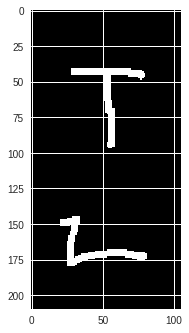

In [0]:
batch_size = 200
[mypairs,mytargets] = generate_trainset(train_x,train_y,batch_size)
myidx = rng.randint(batch_size)
print(np.asarray(mypairs).shape)
plt.imshow(np.asarray(mypairs)[:,myidx,:,:].reshape(2*105,105))
print("target",mytargets[myidx])

In [0]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
  
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

In [0]:
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet

In [0]:
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

In [0]:
both = subtract([encoded_l,encoded_r])
pred = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)

Siamese = Model(input=[left_input,right_input],output=pred)
Siamese.compile(loss='binary_crossentropy',optimizer=Adam(0.00006),metrics=['accuracy'])
print(mytargets.shape[0])

batch_size = 20
[mypairs,mytargets] = generate_trainset(train_x,train_y,batch_size)
epochs = 1000
loss_acc = np.zeros((epochs,2))
for i in range(epochs):
  [mypairs,mytargets] = generate_trainset(train_x,train_y,batch_size)
  loss_acc[i,:] = Siamese.train_on_batch(mypairs,mytargets)
  #print(loss_acc[i,:])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


20


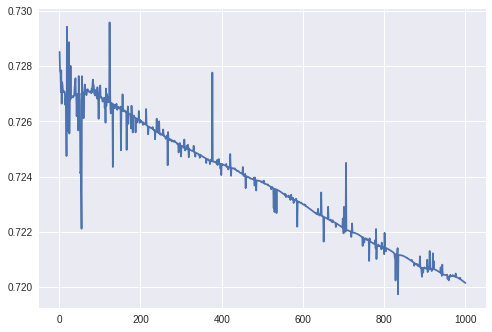

In [0]:
#print(np.linspace(1,epochs,epochs))
plt.plot(np.linspace(1,epochs,epochs),loss_acc[:,0])

(2, 20, 105, 105, 1)
[[0.61008424]] desired: 0.0


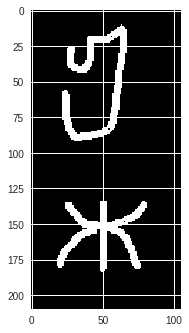

In [0]:
pred =np.asarray(mypairs)
print(pred.shape)
qwi = rng.randint(20)
pred = pred[:,qwi,:,:,:].reshape(2,105,105,1)
right =np.asarray(mypairs[1][qwi,:,:]).reshape(1,105,105,1)
left  =np.asarray(mypairs[0][qwi,:,:]).reshape(1,105,105,1)

print(Siamese.predict([right,left]),"desired:",mytargets[qwi])
plt.imshow(np.asarray([right,left]).reshape(2*105,105))